In [1]:
import pandas as pd
from utils import pca_utils, utils, pca_utils, plots
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_props = pd.read_csv("./output/df_props.csv")

df_authors = pd.read_csv("./output/df_authors.csv")
df_authors["id_dep"] = df_authors["uri"].apply(lambda x: str(x).split("/")[-1])

df_topics_raw = pd.read_csv("./output/df_topics.csv")
df_topics = df_topics_raw.join(pd.get_dummies(df_topics_raw["tema"]))
df_topics = df_topics.loc[:, "id_prop":]

df_authors_topic = (
    df_authors[["id_prop", "id_dep"]]
    .merge(df_topics)
    .loc[:, "id_dep":]
    .groupby("id_dep")
    .sum()
    .reset_index()
)

df_authors_topic.set_index("id_dep", inplace=True)
df_authors_topic = df_authors_topic.iloc[:-1,:] # remove nan idenx

df_locals = pd.read_csv('./output/df_locals_classification_final.csv')

In [3]:
df_authors.describe()

,Unnamed: 0,codTipo,ordemAssinatura,proponente,id_prop
count,520660.000000,520660.000000,520660.000000,520660.000000,5.206600e+05
mean,260329.500000,10468.988989,36.818841,0.599612,2.311239e+06
std,150301.739916,6653.274802,56.621975,0.489977,7.585333e+04
min,0.000000,1.000000,1.000000,0.000000,2.080812e+06
25%,130164.750000,10000.000000,1.000000,0.000000,2.239173e+06
50%,260329.500000,10000.000000,3.000000,1.000000,2.314222e+06
75%,390494.250000,10000.000000,53.000000,1.000000,2.369797e+06
max,520659.000000,81009.000000,333.000000,1.000000,2.450295e+06


# temas

In [4]:
def calculate_theil_entropy(row):
    total = row.sum()  # Total of values in the row
    mean = total / len(row)  # Mean value in the row
    n = len(row)

    entropy = 0
    for r in row:
        if r and r > 0:  # Avoid division by zero
            share = r / total
            entropy += share * np.log(1 / share)

    return 1 - (1 / np.log(n)) * entropy  # Normalize by number of elements


df_authors_topic["theil"] = [
    calculate_theil_entropy(row) for _, row in df_authors_topic.iterrows()
]

<Axes: ylabel='Frequency'>

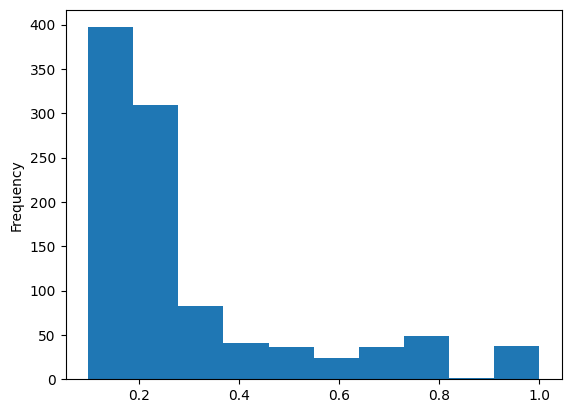

In [5]:
df_authors_topic['theil'].plot(kind='hist')

# atividade

In [6]:
def normalize_minmax(column):
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)

<Axes: ylabel='Frequency'>

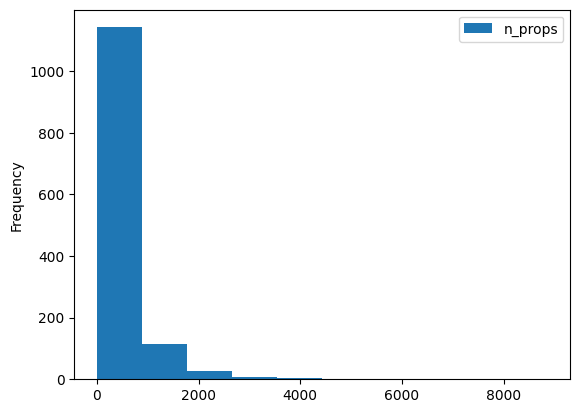

In [7]:
df_activity = (
    df_authors[["id_prop", "id_dep"]]
    .groupby("id_dep")
    .count()
    .rename({"id_prop": "n_props"}, axis=1)
)
# remove nan id
df_activity = df_activity.iloc[:-1,:]

df_activity.plot(kind="hist")

In [8]:
df_activity['norm_freq'] = normalize_minmax(df_activity['n_props'])

df_activity['n_props_log'] = np.log(df_activity['n_props'])
df_activity['norm_props_log'] = normalize_minmax(df_activity['n_props_log'])

In [9]:
df_activity

,n_props,norm_freq,n_props_log,norm_props_log
id_dep,,,,
100011,1,0.000000,0.000000,0.000000
100070,42,0.004623,3.737670,0.411170
100095,2,0.000113,0.693147,0.076251
100177,2,0.000113,0.693147,0.076251
100292,1779,0.200496,7.483807,0.823272
...,...,...,...,...
93083,638,0.071831,6.458338,0.710463
97707,1,0.000000,0.000000,0.000000
98057,1347,0.151782,7.205635,0.792671


# abrangencia

<Axes: ylabel='Frequency'>

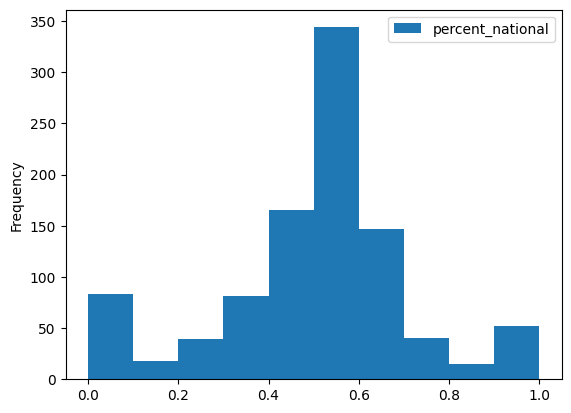

In [3]:
df_abrang = (
    df_authors.merge(df_locals, on="id_prop")[["id_dep", "clf"]]
    .groupby("id_dep")
    .mean("clf")
    .rename({"clf": "percent_national"}, axis=1)
)

df_abrang.plot(kind='hist')

In [5]:
df_abrang.describe()

,percent_national
count,984.000000
mean,0.501419
std,0.221204
min,0.000000
25%,0.417458
50%,0.526794
75%,0.606444
max,1.000000


# merge

In [11]:
import matplotlib.pyplot as plt

In [12]:
df_merge = df_authors_topic.join(df_activity).join(df_abrang).fillna(0)
df_merge

,Administração Pública,"Agricultura, Pecuária, Pesca e Extrativismo","Arte, Cultura e Religião",Cidades e Desenvolvimento Urbano,"Ciência, Tecnologia e Inovação",Ciências Exatas e da Terra,Ciências Sociais e Humanas,Comunicações,Defesa e Segurança,Direito Civil e Processual Civil,...,Saúde,Trabalho e Emprego,Turismo,"Viação, Transporte e Mobilidade",theil,n_props,norm_freq,n_props_log,norm_props_log,percent_national
id_dep,,,,,,,,,,,,,,,,,,,,,
100292,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0.535614,1779,0.200496,7.483807,0.823272,0.000000
100313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.000000,21,0.002255,3.044522,0.334919,0.000000
100314,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.000000,4,0.000338,1.386294,0.152502,0.000000
100322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.000000,41,0.004511,3.713572,0.408520,0.000000
100420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.000000,11,0.001128,2.397895,0.263786,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92776,1,1,1,0,0,0,0,0,5,0,...,0,1,0,1,0.193563,344,0.038678,5.840642,0.642512,0.717949
93083,9,0,1,0,0,0,0,2,3,0,...,4,5,0,0,0.262266,638,0.071831,6.458338,0.710463,0.600000
98057,16,2,2,1,0,0,0,3,9,3,...,7,10,0,3,0.140098,1347,0.151782,7.205635,0.792671,0.568627


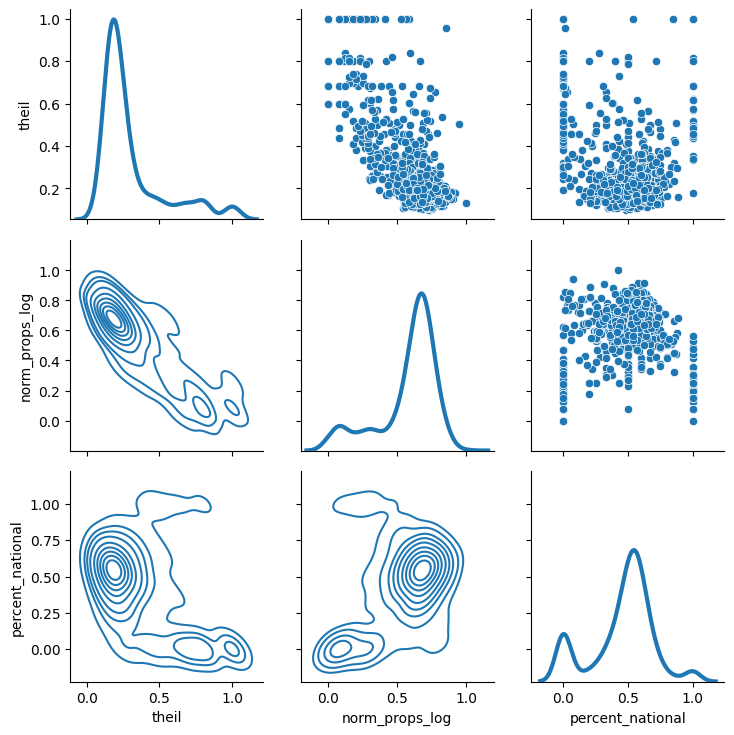

In [13]:
label_props = 'norm_props_log'
label_theil = 'theil'
label_abrg = 'percent_national'


g = sns.PairGrid(df_merge[[label_theil, label_props, label_abrg]])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False) 

# Cluster

In [14]:
from utils import utils

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [15]:
def cluster_dataframe(
    df,
    techniques=["kmeans", "dbscan", "gmm"],
    k_value=3,
    eps=0.5,
    min_samples=5,
):
    """
    Clusters the input DataFrame using k-means, DBSCAN, and GMM algorithms.

    Args:
        df (pd.DataFrame): The DataFrame to be clustered.
        k_value (int, optional): Number of clusters for k-means. Defaults to 3.
        eps (float, optional): Maximum distance between two samples for DBSCAN. Defaults to 0.5.
        min_samples (int, optional): Minimum number of samples in a neighborhood for DBSCAN. Defaults to 5.

    Returns:
        pd.DataFrame: The original DataFrame with added columns for cluster labels from each algorithm.
    """

    df_c = df.copy()

    # K-means
    if "kmeans" in techniques:
        kmeans = KMeans(n_clusters=k_value, random_state=0).fit(df)
        df_c["k_means_cluster"] = kmeans.labels_

    # DBSCAN
    if "dbscan" in techniques:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
        df_c["dbscan_cluster"] = dbscan.labels_

    # Gaussian Mixture Model (GMM)
    if "gmm" in techniques:
        gmm = GaussianMixture(n_components=k_value, random_state=0).fit(df)
        df_c["gmm_cluster"] = gmm.predict(df)

    return df_c


def melt_df(df, val_columns, cluster_column="Cluster"):
    # Melt the DataFrame
    df_melted = df.reset_index().melt(
        id_vars=["id_dep", cluster_column],  # Keep these as identifier columns
        value_vars=val_columns,
        var_name="var",
        value_name="value",
    )

    df_melted["value"] = df_melted["value"].astype(float)

    return df_melted


def plot_melted_df(df_melted, hue_col="Cluster", figsize=(12, 8), xticks_rotation=45):
    # Set the desired figure size (width, height) in inches
    plt.figure(figsize=figsize)

    # Create the Seaborn boxplot
    sns.boxplot(data=df_melted, x="var", y="value", hue=hue_col)

    # Optional: Adjust layout for better readability (especially with many boxes)
    plt.xticks(rotation=xticks_rotation, ha="right")  # Rotate x-axis labels if needed

    # Show the plot
    plt.tight_layout()
    plt.show()

In [1]:
x_label = "theil"
y_label = "n_props_log"
z_label = "percent_national"
k_value = 4
eps = 0.1
min_samples = 5

for k_value in range (2,5):
    df_cluster = cluster_dataframe(
        df_merge[[x_label, y_label, z_label]], k_value=k_value, eps=eps, min_samples=min_samples
    )

    x = df_cluster[x_label]
    y = df_cluster[y_label]


    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

    # Scatter plot 1
    axs[0].scatter(x=x, y=y, c=df_cluster["k_means_cluster"])
    axs[0].set_title("k_means_cluster")
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel(y_label)

    # Scatter plot 2
    axs[1].scatter(x=x, y=y, c=df_cluster["dbscan_cluster"])
    axs[1].set_title("dbscan_cluster")
    axs[1].set_xlabel(x_label)
    axs[1].set_ylabel(y_label)

    # Scatter plot 3
    axs[2].scatter(x=x, y=y, c=df_cluster["gmm_cluster"])
    axs[2].set_title("gmm_cluster")
    axs[2].set_xlabel(x_label)
    axs[2].set_ylabel(y_label)
    plt.show()

NameError: name 'cluster_dataframe' is not defined

Parameter: {'n_clusters': 2} Score 0.7318193695244347
Parameter: {'n_clusters': 3} Score 0.5087001904891023
Parameter: {'n_clusters': 4} Score 0.4924703101591335
Parameter: {'n_clusters': 5} Score 0.47699161514542654
Parameter: {'n_clusters': 10} Score 0.4228430907593597


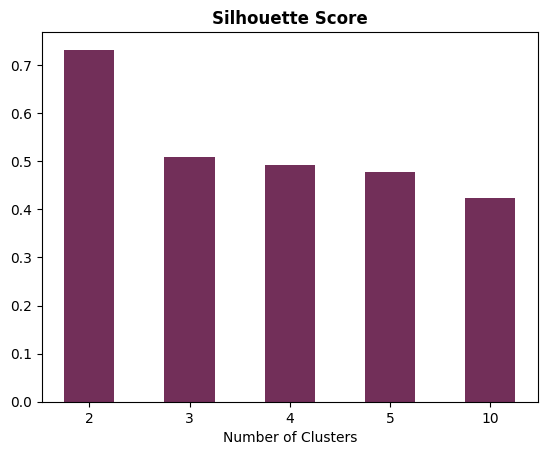

In [17]:
plots.plot_silhouette_score(df_merge[[x_label, y_label, z_label]])

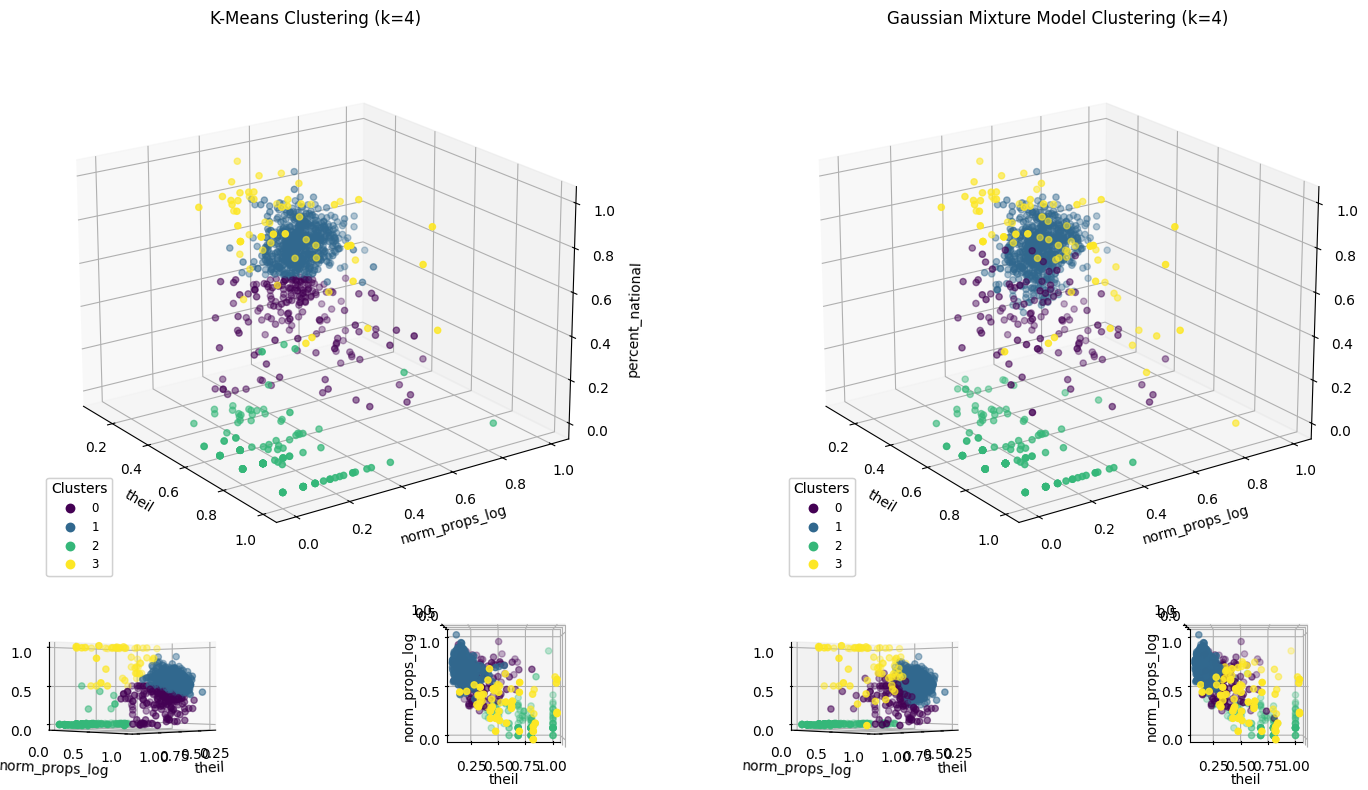

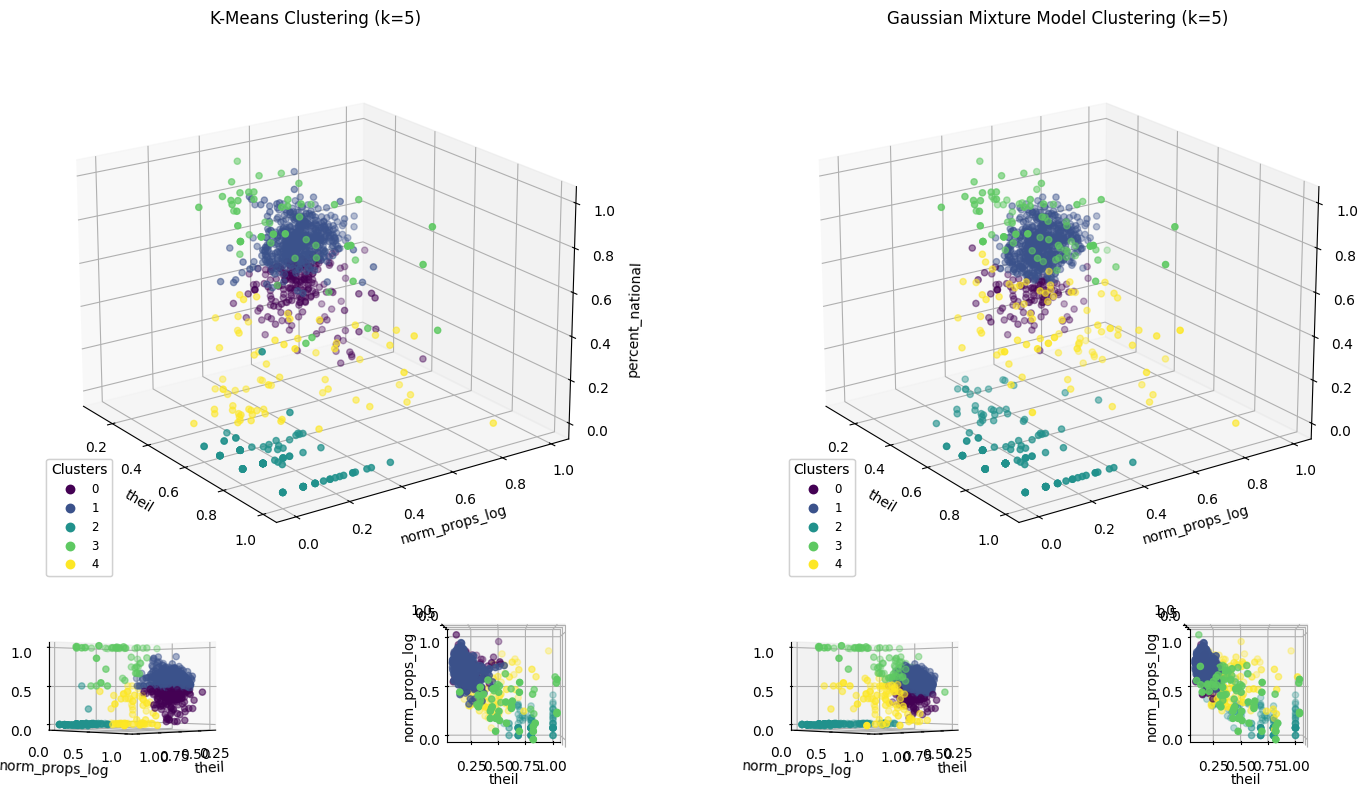

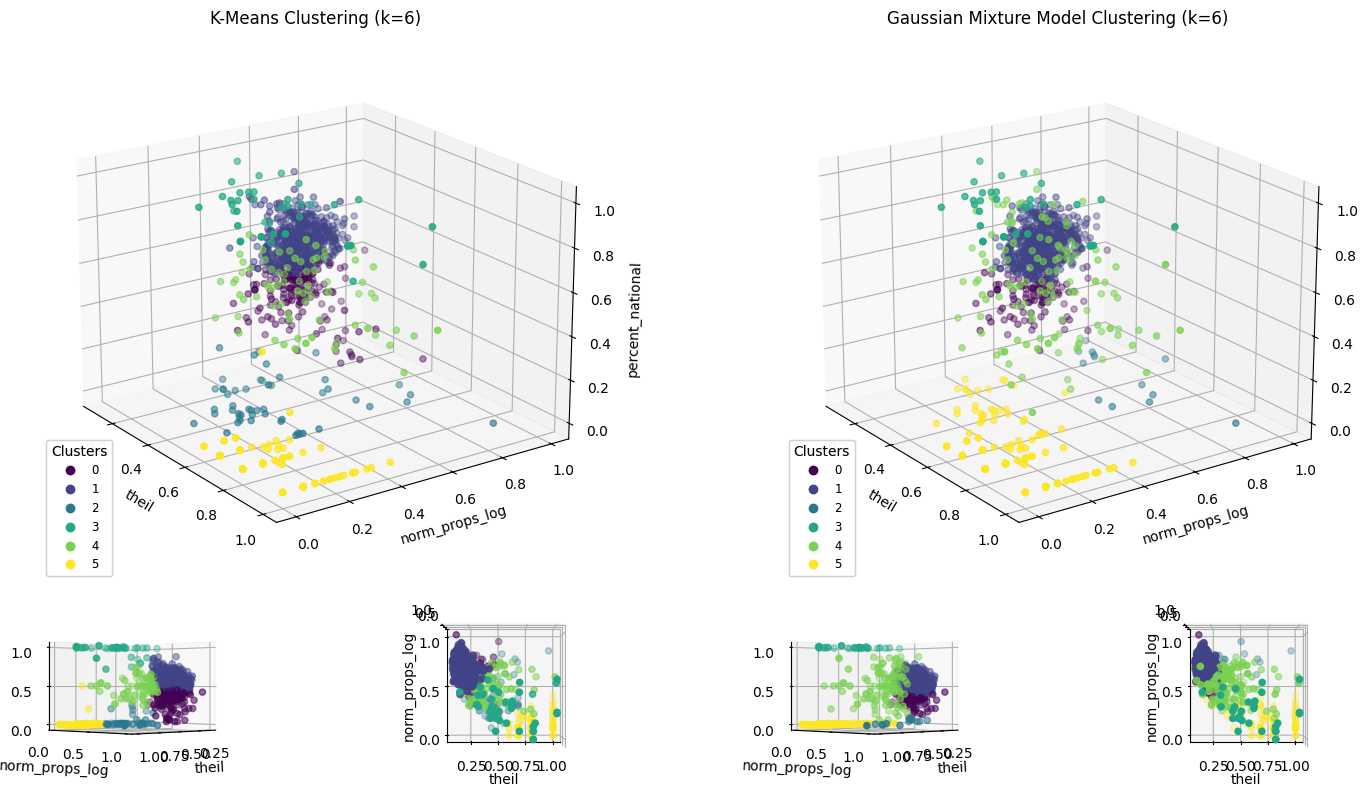

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_label = "theil"
y_label = "norm_props_log"
z_label = "percent_national"
k_value = 4
eps = 0.1
min_samples = 5

for k_value in range(4, 7):
    df_cluster = cluster_dataframe(
        df_merge[[x_label, y_label, z_label]],
        k_value=k_value,
        eps=eps,
        min_samples=min_samples,
    )
    unique_clusters = range(0, k_value)

    # Create figure and axes for side-by-side main plots and subplots
    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(2, 4, height_ratios=[3, 1], width_ratios=[1, 1, 1, 1]) 

    # --- K-Means Plots ---
    # Main plot
    ax1 = fig.add_subplot(gs[0, 0:2], projection='3d') 
    scatter = ax1.scatter(df_merge[x_label], df_merge[y_label], df_merge[z_label], c=df_cluster["k_means_cluster"], cmap='viridis', label=f'K-Means (k={k_value})')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_zlabel(z_label)
    # Create a custom legend
    legend1 = ax1.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters", fontsize="small")
    ax1.add_artist(legend1)  # Add the legend back to the axes

    ax1.view_init(elev=20, azim=-35)
    ax1.set_title(f'K-Means Clustering (k={k_value})')

    # Mini plots
    for i in range(2):
        ax = fig.add_subplot(gs[1, i], projection='3d')
        ax.scatter(df_merge[x_label], df_merge[y_label], df_merge[z_label], c=df_cluster["k_means_cluster"], cmap='viridis')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        # ax.set_zlabel(z_label)
        ax.view_init(elev=[0, 90][i], azim=[45, -90][i])

    # --- GMM Plots ---
    # Main plot
    ax4 = fig.add_subplot(gs[0, 2:4], projection='3d')
    scatter = ax4.scatter(df_merge[x_label], df_merge[y_label], df_merge[z_label], c=df_cluster["gmm_cluster"], cmap='viridis', label=f'GMM (k={k_value})')
    ax4.set_xlabel(x_label)
    ax4.set_ylabel(y_label)
    ax4.set_zlabel(z_label)
    # Create a custom legend
    legend2 = ax4.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters", fontsize="small")
    ax4.add_artist(legend2)  # Add the legend back to the axes

    ax4.view_init(elev=20, azim=-35)
    ax4.set_title(f'Gaussian Mixture Model Clustering (k={k_value})')
    
    # Mini plots
    for i in range(2):
        ax = fig.add_subplot(gs[1, i+2], projection='3d')
        ax.scatter(df_merge[x_label], df_merge[y_label], df_merge[z_label], c=df_cluster["gmm_cluster"], cmap='viridis')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        # ax.set_zlabel(z_label)
        ax.view_init(elev=[0, 90][i], azim=[45, -90][i])

    plt.tight_layout()
    plt.show()

In [19]:
df_cluster = cluster_dataframe(df_merge[[x_label, y_label, z_label]], k_value=8, eps=eps, min_samples=min_samples)

df_merge.join(df_cluster[["k_means_cluster", "gmm_cluster"]]).to_excel(
    "./output/df_final_cluster_k8.xlsx"

)
df_cluster = cluster_dataframe(df_merge[[x_label, y_label, z_label]], k_value=4, eps=eps, min_samples=min_samples)

df_merge.join(df_cluster[["k_means_cluster", "gmm_cluster"]]).to_excel(
    "./output/df_final_cluster_k4.xlsx"
)

In [20]:
df_cluster = cluster_dataframe(df_merge[[x_label, y_label, z_label]], k_value=5, eps=eps, min_samples=min_samples)

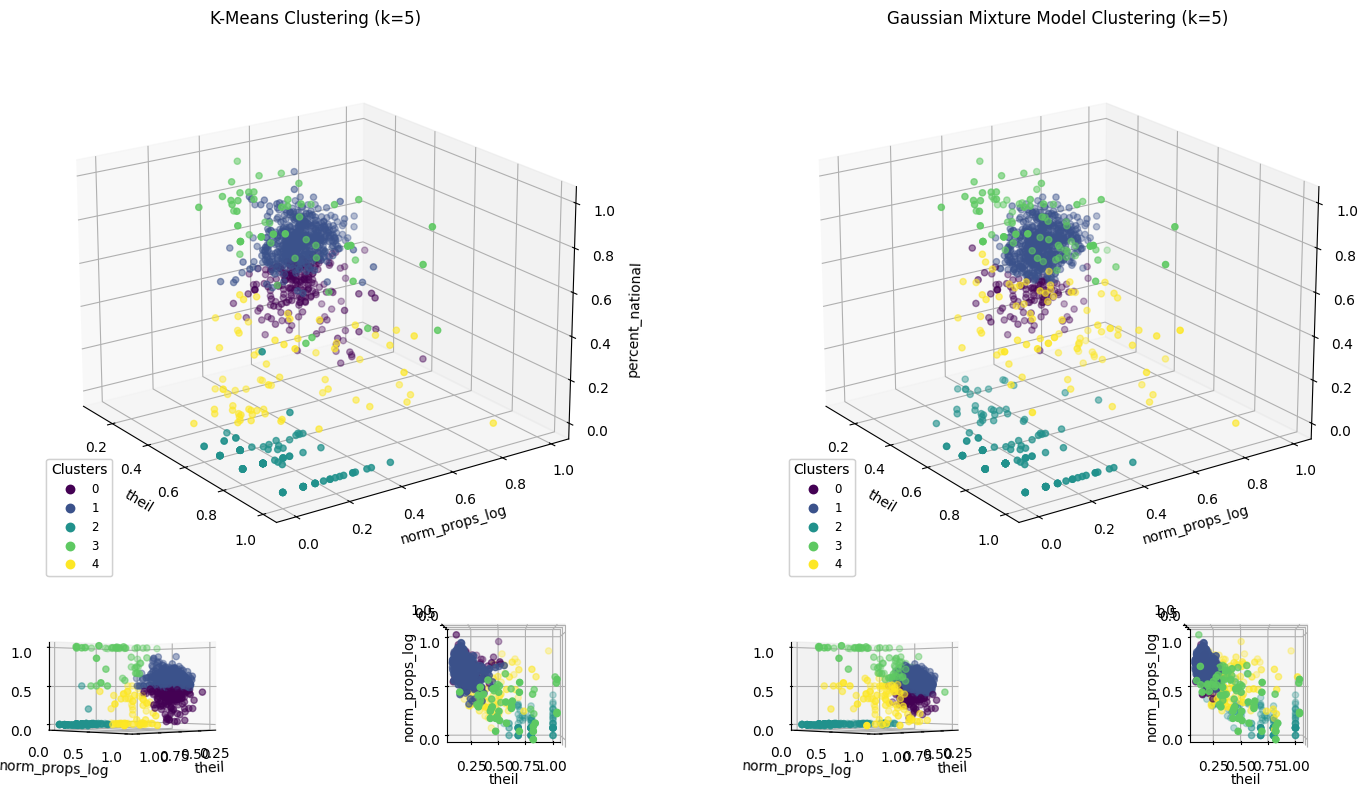

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_label = "theil"
y_label = "norm_props_log"
z_label = "percent_national"
k_value = 5
eps = 0.1
min_samples = 5

unique_clusters = range(0, k_value)

# Create figure and axes for side-by-side main plots and subplots
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(2, 4, height_ratios=[3, 1], width_ratios=[1, 1, 1, 1]) 

# --- K-Means Plots ---
# Main plot
ax1 = fig.add_subplot(gs[0, 0:2], projection='3d') 
scatter = ax1.scatter(df_merge[x_label], df_merge[y_label], df_merge[z_label], c=df_cluster["k_means_cluster"], cmap='viridis', label=f'K-Means (k={k_value})')
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_zlabel(z_label)
# Create a custom legend
legend1 = ax1.legend(*scatter.legend_elements(),
                loc="lower left", title="Clusters", fontsize="small")
ax1.add_artist(legend1)  # Add the legend back to the axes

ax1.view_init(elev=20, azim=-35)
ax1.set_title(f'K-Means Clustering (k={k_value})')

# Mini plots
for i in range(2):
    ax = fig.add_subplot(gs[1, i], projection='3d')
    ax.scatter(df_merge[x_label], df_merge[y_label], df_merge[z_label], c=df_cluster["k_means_cluster"], cmap='viridis')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    # ax.set_zlabel(z_label)
    ax.view_init(elev=[0, 90][i], azim=[45, -90][i])

# --- GMM Plots ---
# Main plot
ax4 = fig.add_subplot(gs[0, 2:4], projection='3d')
scatter = ax4.scatter(df_merge[x_label], df_merge[y_label], df_merge[z_label], c=df_cluster["gmm_cluster"], cmap='viridis', label=f'GMM (k={k_value})')
ax4.set_xlabel(x_label)
ax4.set_ylabel(y_label)
ax4.set_zlabel(z_label)
# Create a custom legend
legend2 = ax4.legend(*scatter.legend_elements(),
                loc="lower left", title="Clusters", fontsize="small")
ax4.add_artist(legend2)  # Add the legend back to the axes

ax4.view_init(elev=20, azim=-35)
ax4.set_title(f'Gaussian Mixture Model Clustering (k={k_value})')

# Mini plots
for i in range(2):
    ax = fig.add_subplot(gs[1, i+2], projection='3d')
    ax.scatter(df_merge[x_label], df_merge[y_label], df_merge[z_label], c=df_cluster["gmm_cluster"], cmap='viridis')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    # ax.set_zlabel(z_label)
    ax.view_init(elev=[0, 90][i], azim=[45, -90][i])

plt.tight_layout()
plt.show()

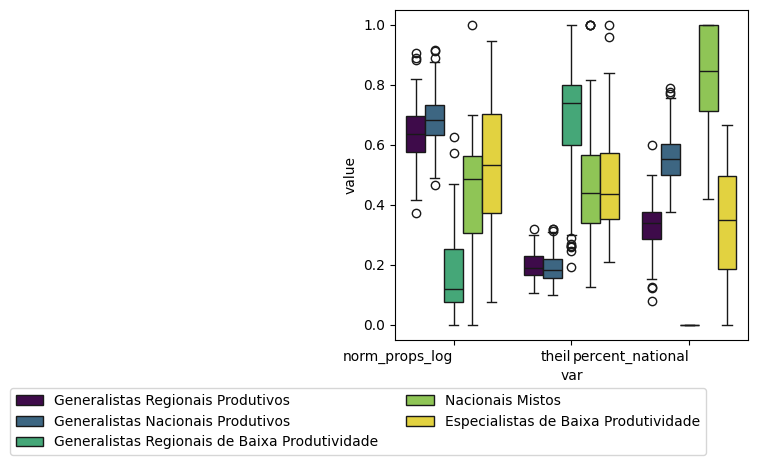

In [22]:
clusterization = 'gmm_cluster'#'k_means_cluster'

# Melt the DataFrame
df_melted = df_cluster.reset_index().melt(
    id_vars=["id_dep", clusterization],  # Keep these as identifier columns
    value_vars=["theil", "norm_props_log", "percent_national"],
    var_name="var",
    value_name="value",
)

df_melted["value"] = df_melted["value"].astype(float)


rename_dict = {
    0: ("Generalistas Regionais Produtivos", "#440154"),
    1: ("Generalistas Nacionais Produtivos", "#31688E"),
    2: ("Generalistas Regionais de Baixa Produtividade", "#35B779"),
    3: ("Nacionais Mistos", "#8FD744"),
    4: ("Especialistas de Baixa Produtividade", "#FDE725"),
    5: ("Cluster 5", "g"),
    6: ("Cluster 6", "g"),
    7: ("Cluster 7", "g"),
}


def rename(x):
    return rename_dict.get(x)[0]


df_melted['cluster_name'] = df_melted[clusterization].apply(rename)


# Set the desired figure size (width, height) in inches
plt.figure()
# plt.figure(figsize=(5,5))

# Create the Seaborn boxplot
my_pal = {v[0]:v[1] for k, v in rename_dict.items()}

sns.boxplot(data=df_melted.sort_values(clusterization), x="var", y="value", hue='cluster_name', palette=my_pal)
# sns.boxplot(data=df_melted, x="var", y="value", hue=clusterization)

plt.xticks(rotation=0, ha="right") 
plt.legend(ncol=2, bbox_to_anchor=(.9, -.125))
plt.tight_layout()
plt.show()

C:\Users\caca_\AppData\Local\Temp\ipykernel_18928\3320454336.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data, palette=my_pal)
C:\Users\caca_\AppData\Local\Temp\ipykernel_18928\3320454336.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


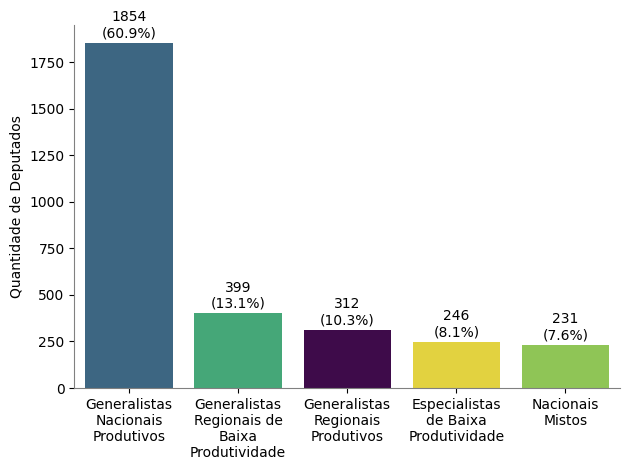

In [23]:
import textwrap

plt.figure()

data = df_melted.groupby("cluster_name").count().sort_values("var", ascending=False)["var"]

# Calculate percentages
total = data.sum()
percentages = (data / total) * 100

# Create the bar plot with colors from the palette
ax = sns.barplot(data, palette=my_pal)

# Wrap xtick labels to multiple lines
max_label_width = 15
xticks = ax.get_xticklabels()
new_labels = [textwrap.fill(label.get_text(), max_label_width) for label in xticks]
ax.set_xticklabels(new_labels)

# Add data labels with both count and percentage
for container, p in zip(ax.containers, percentages):
    ax.bar_label(container, labels=[f"{int(v.get_height())}\n({p:.1f}%)" for v in container], label_type="edge", padding=2)

# Visual enhancements
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')

plt.xlabel("")
plt.ylabel("Quantidade de Deputados")
# plt.title("Cluster Counts and Percentages")

plt.tight_layout()
plt.show()


# linear regression between norm_props_log and theil

In [55]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [59]:
X = df_cluster["norm_props_log"].values
y = df_cluster["theil"].values

X_sm = sm.add_constant(X)
model_sm = sm.OLS(y, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     1807.
Date:                Fri, 26 Jul 2024   Prob (F-statistic):          2.18e-227
Time:                        12:45:56   Log-Likelihood:                 602.68
No. Observations:                1014   AIC:                            -1201.
Df Residuals:                    1012   BIC:                            -1192.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7953      0.012     64.880      0.0